<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">M2.875 · Deep Learning · PRAC</p>
<p style="margin: 0; text-align:right;">2020-2 · Máster universitario en Ciencia de datos (Data science)</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudios de Informática, Multimedia y Telecomunicación</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>

# Deep Learning

### Implementación de un algoritmo para la clasificación de enfermedades foliares del árbol del manzano.

Nombre: **Adonis González Godoy**

## 1. Contexto y carga de librerías Librerías

### 1.1 Definición del problema

<div style="text-align: justify">
Las manzanas son uno de los cultivos de fruta más importantes del mundo. Las
enfermedades foliares (de hojas) representan una amenaza importante para la
productividad y la calidad generales de los manzanos. El proceso actual para el diagnóstico de enfermedades en los huertos de manzanos se basa en la exploración manual por parte de los humanos, que requiere mucho tiempo.
</div>
<br>
<div style="text-align: justify">
Aunque los modelos basados en la visión por computador han demostrado ser
prometedores para la identificación de enfermedades de plantas, hay algunas
limitaciones que hay que abordar. Las grandes variaciones en los síntomas visuales de una sola enfermedad entre diferentes cultivos de manzana son los principales retos para la identificación de enfermedades basadas en la visión por computador. Estas variaciones surgen de las diferencias en entornos naturales y de captura de imágenes,por ejemplo, el color y la morfología de las hojas, la edad de los tejidos infectados, el fondo de la imagen no uniforme y las variaciones de las condiciones de iluminación durante la toma de la imagen entre otros.
</div>

<div style="text-align: justify">
El conjunto de datos de la práctica, etiquetado por expertos atendiendo a la enfermedad foliar de
la manzana, está formado por dos conjuntos de imágenes: uno de entrenamiento formado por 9.750 imágenes RGB y otro de test sin clasificar formado por un total de 7.527 imágenes. 
</div>

<br>

<div style="text-align: justify">    
Para facilitar el preprocesamiento, las imágenes se suministran con una resolución reducida. La clase C0 es de hojas sanas y las clases C1 a C5 de diferentes tipos de enfermedades. Este conjunto de datos refleja escenarios de campo reales, representando fondos no homogéneos de imágenes de hojas tomadas en diferentes etapas de madurez y en diferentes momentos del día bajo diferentes parámetros de exposición de la cámara.
</div>

### 1.2 Objetivos

<div style="text-align: justify">    
El objetivo principal de la práctica es desarrollar modelos basados en el aprendizaje
automático para clasificar con precisión la enfermedad que afecta a la hoja de la
fotografía analizada.
</div>

## 2. Exploración y preprocesado de los datos

<div style="text-align: justify"> 
En este apartado exploraremos la base de datos y prepararemos la carga de las imágenes para los modelos de los siguientes apartados.

Las imágenes se encuentran en el path _data/Images/_ y se dan en formato ".jpg". 
    
Cada subdirectorio tiene el nombre de la categoría: `C1`, `C2`, `C3`, `C4`, `C5`.
</div>

### 2.1 Librerías

Cargamos todas las librerías necesarias, las principales a destacar son: Tensorflow, Keras, Numpy y Matplotlib.

La versión de Tensorflow es la __2.4.1__. Se utiliza un enviroment conda que se ejectua sobre la versión 3.6 de Python. El código será presetando sobre este mismo Jupyter Notebook.

El hardware para usar este problema será una GPU GeForce RTX 2080.

In [1]:
# All rellevant imports
import tensorflow as tf

print("TF version   : ", tf.__version__)
# we'll need GPU!
print("GPU available: ", tf.config.list_physical_devices('GPU'))

# keras version is 2.4.3
import keras
print("Keras version   : ", keras.__version__)

TF version   :  2.4.1
GPU available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Keras version   :  2.4.3


In [2]:
from tensorflow.python.client import device_lib
print(tf.test.gpu_device_name())

local_prot = device_lib.list_local_devices()
print([x.physical_device_desc for x in local_prot if x.device_type == 'GPU'])


/device:GPU:0
['device: 0, name: GeForce RTX 2080 SUPER, pci bus id: 0000:2d:00.0, compute capability: 7.5']


In [3]:
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import (
    GlobalAveragePooling2D, Multiply, Flatten,
     Dense, Dropout, Conv2D, BatchNormalization, MaxPooling2D)
from keras.layers.experimental.preprocessing import Resizing

from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint

from keras.optimizers import Adam
from keras import Sequential, Model
from keras.applications.vgg16 import VGG16
from keras import applications
from tensorflow.keras.layers import Lambda
from tensorflow.image import resize
from keras.applications.resnet import preprocess_input
import tensorflow_addons as tfa
from keras import Input

In [4]:
%pylab inline
import cv2
import glob
import os
import pandas as pd
import matplotlib.pylab as plt

from matplotlib import image
from matplotlib import pyplot

import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


B:\software\miniConda\envs\models\lib\site-packages\IPython\core\magics\pylab.py:159: UserWarning: pylab import has clobbered these variables: ['resize']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight
import itertools

### 2.2 Exploración del dataset

In [6]:
ROOT_DIR = os.path.abspath("")
data_dir = os.path.join(ROOT_DIR, "data")

train_dir = os.path.join(data_dir, "train")
test_dir = os.path.join(data_dir, "test")

In [7]:
NUM_IMG_TO_SHOW = 5
subdirs = [os.path.join(train_dir, x) for x in os.listdir(train_dir)]
labels_name = [x for x in os.listdir(train_dir)]

In [8]:
total, category_image = [], []
for subdir in subdirs:
    for i in range(0, len(os.listdir(subdir))):
        if i == NUM_IMG_TO_SHOW:
            break
        else:
            category_image.append(os.path.join(subdir, os.listdir(subdir)[i]))
    total.append(len(os.listdir(subdir)))

<Figure size 432x288 with 0 Axes>

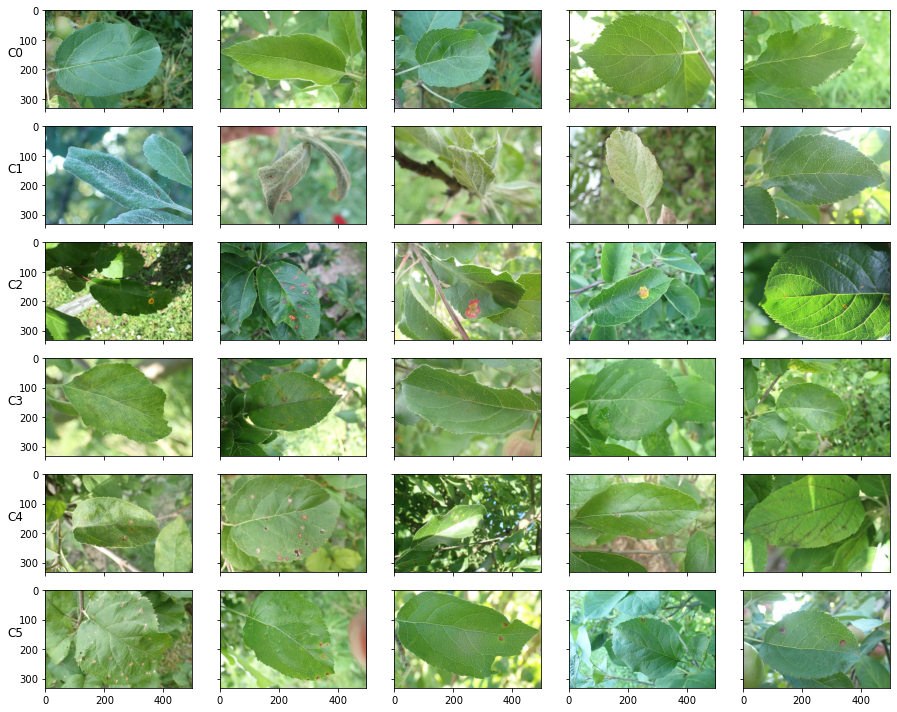

In [9]:
ncols = NUM_IMG_TO_SHOW
nrow = int(len(labels_name))

fig = plt.figure()
fig, ax = plt.subplots(nrow, ncols, figsize=(13,10), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.3, wspace=0)

for i, axi in enumerate(ax.flat):
    axi.imshow(image.imread(category_image[i]))

for ax, row in zip(ax[:,0], labels_name):
    ax.set_ylabel(row, rotation=0, fontsize=12)
        
fig.tight_layout()
plt.show()

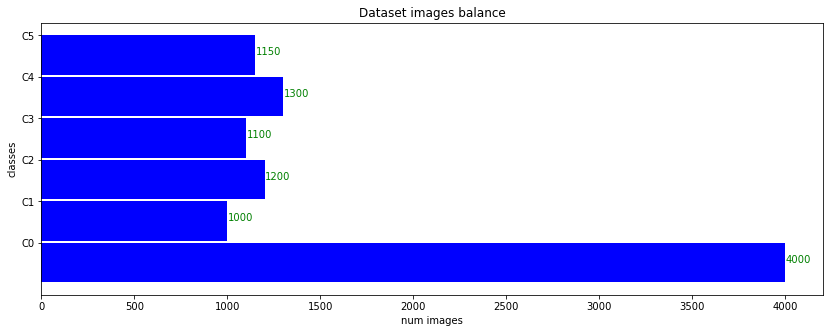

In [10]:
fig, ax = plt.subplots(figsize=(14,5))   
width = 0.95

ind = np.arange(len(total))
ax.barh(ind, total, width, color="blue")

ax.set_yticks(ind+width/2)
ax.set_yticklabels(labels_name)

plt.title('Dataset images balance')
plt.xlabel('num images')
plt.ylabel('classes')

percen = []
for i, v in enumerate(total):
    ax.text(v + 3, i, str(v), color='green',)
    percen.append((v, i))
plt.show()

Porcentaje de imágenes del dataset:

In [11]:
total = sum([pair[0] for pair in percen])
for i in percen:
    print('Porcentaje de img de la clase C'+ str(i[1]) + ' '+ "{:.2f}".format(i[0] * 100 / total) + '%')

Porcentaje de img de la clase C0 41.03%
Porcentaje de img de la clase C1 10.26%
Porcentaje de img de la clase C2 12.31%
Porcentaje de img de la clase C3 11.28%
Porcentaje de img de la clase C4 13.33%
Porcentaje de img de la clase C5 11.79%


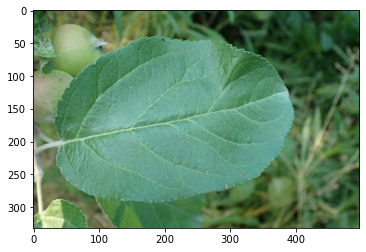

In [12]:
plt.imshow(imread(category_image[0]))
plt.show()

## 2.3 preprocesado de los datos

Estableceremos los diferentes conjuntos de datos, para el set de entrenamiento usaremos el 80% y el 20% para el conjunto de validación.

Para el conjunto de test ya tenemos definido nuestro subset.

In [13]:
HEIGHT = 224
WIDTH = 224

In [14]:
datagen = ImageDataGenerator(rescale=1/255.0, 
                                    zoom_range=0.2, 
                                    width_shift_range=0.1, 
                                    height_shift_range = 0.1, 
                                    rotation_range=15,
                                    fill_mode="nearest",
                                    validation_split=0.20)

train = datagen.flow_from_directory(train_dir,
                                    shuffle=True,
                                    target_size=(HEIGHT, WIDTH),
                                    subset='training',
                                    class_mode='categorical')

val = datagen.flow_from_directory(train_dir,
                                    shuffle=False,
                                    target_size=(HEIGHT, WIDTH),
                                    subset='validation',
                                    class_mode='categorical')

Found 7800 images belonging to 6 classes.
Found 1950 images belonging to 6 classes.


## 3. Modelos

In [15]:
NUM_CLASSES = len(labels_name) 
NUM_TRAIN = len(train.filenames)
NUM_VAL = len(val.filenames)
LR = 0.0001
EPOCHS = 30
BATCH_SIZE = 32
VERBOSE = 1

Functions para printar resultados:

In [16]:
def plot_accuracy(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epochs')
    plt.legend(['Train acc', 'Val acc'], loc='upper right')
    plt.show()
    
def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss']) 
    plt.title('Model loss') 
    plt.ylabel('Loss') 
    plt.xlabel('Epochs') 
    plt.legend(['Train loss', 'Val loss'], loc='upper right') 
    plt.show()
    
def plot_f1(history):
    plt.plot(history.history['f1_score'])
    plt.plot(history.history['val_f1_score']) 
    plt.title('Model F1') 
    plt.ylabel('f1') 
    plt.xlabel('Epochs') 
    plt.legend(['Train f1', 'Val f1'], loc='upper right') 
    plt.show()
    
def plot_cm(cm):
    fig = plt.figure(figsize=(15,15))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)

    plt.title('Confusion matrix')
    fig.colorbar(cax)

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j],'d'),
                 horizontalalignment="center",
                 color="white", 
                 fontsize=12)

    ticks = np.arange(len(labels_name))
    plt.xticks(ticks, labels_name, rotation=90)
    plt.yticks(ticks, labels_name)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

Callbacks:

In [17]:
METRIC = "val_f1_score"
PATH = './model.h5'

def create_callbacks(metric = METRIC, path = PATH):
    checkpoint = ModelCheckpoint(
        filepath=path,
        monitor= metric,
        mode='max',
        save_best_only=True,
        verbose=1)

    reducelr = ReduceLROnPlateau(
        monitor= metric,
        mode='max',
        factor=0.1,
        patience=3,
        verbose=0)

    eS = EarlyStopping(
        monitor= metric,
        mode='max',
        patience=10, 
        verbose=2)
    
    callbacks = [checkpoint, reducelr, eS]         
    return callbacks

 Compile models function:

In [18]:
def compile_model(model, lr=LR):
    optimizer = tf.keras.optimizers.Adam(lr=lr)
    loss = tf.keras.losses.CategoricalCrossentropy()
    
    metrics = [tfa.metrics.F1Score(num_classes = len(labels_name),average = "macro",name = "f1_score"), 
               'accuracy']
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    return model

### 3.1 Red convolucional profunda - VGG16

In [19]:
callbacks = create_callbacks(path='./model_vgg.h5')

In [20]:
def create_model_vgg():
    dropout = 0.001
    fc_layers = [1024, 1024]
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(HEIGHT, WIDTH, 3))
    num_classes = len(labels_name)
    
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = Flatten()(x)
    for fc in fc_layers:
        x = Dense(fc, activation='relu')(x) # New FC layer, random init
        x = Dropout(dropout)(x)

    predictions = Dense(num_classes, activation='softmax')(x) # New softmax layer
    
    finetune_model = Model(inputs=base_model.input, outputs=predictions)
    return finetune_model

In [21]:
model_vgg = create_model_vgg()
model_vgg = compile_model(model_vgg)

In [22]:
model_vgg.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [23]:
history_vgg = model_vgg.fit_generator(train, 
                                    epochs=EPOCHS, 
                                    workers=16, 
                                    steps_per_epoch=NUM_TRAIN // BATCH_SIZE, 
                                    validation_data=val, 
                                    validation_steps=NUM_VAL // BATCH_SIZE,
                                    shuffle=True, 
                                    callbacks=callbacks)

Epoch 1/30
243/243 [==============================] - 33s 110ms/step - loss: 1.4202 - f1_score: 0.3333 - accuracy: 0.4772 - val_loss: 1.1875 - val_f1_score: 0.5035 - val_accuracy: 0.5422f1_score: 0.2727  - ETA: 6s - loss: 1.4966 - ETA: 4s - loss: 1.4630 - f1_sc - ETA: 2s - loss: 1.4397 - f1_scor

Epoch 00001: val_f1_score improved from -inf to 0.50354, saving model to .\model_vgg.h5
Epoch 2/30
243/243 [==============================] - 22s 90ms/step - loss: 1.0473 - f1_score: 0.5425 - accuracy: 0.6191 - val_loss: 0.9367 - val_f1_score: 0.6041 - val_accuracy: 0.6755

Epoch 00002: val_f1_score improved from 0.50354 to 0.60413, saving model to .\model_vgg.h5
Epoch 3/30
243/243 [==============================] - 21s 84ms/step - loss: 0.8876 - f1_score: 0.6256 - accuracy: 0.6833 - val_loss: 1.0355 - val_f1_score: 0.5257 - val_accuracy: 0.6526- ETA: 1s - loss: 0.8862 - f1_score

Epoch 00003: val_f1_score did not improve from 0.60413
Epoch 4/30
243/243 [==============================] - 21s 8

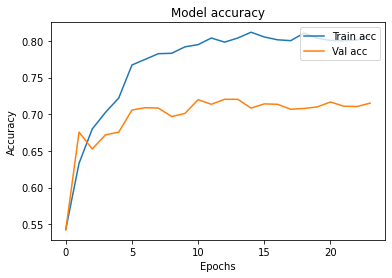

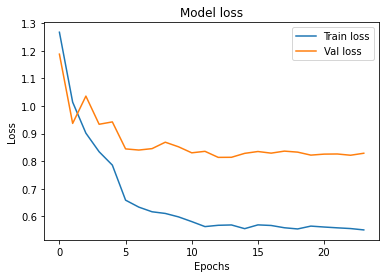

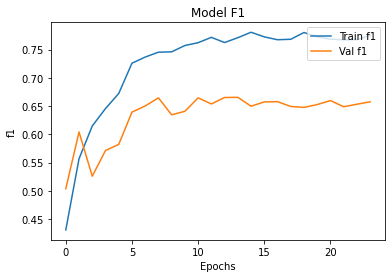

In [24]:
plot_accuracy(history_vgg)
plot_loss(history_vgg)
plot_f1(history_vgg)

In [25]:
val_pred=model_vgg.predict(val,verbose=0)
predicted_class_indices=np.argmax(val_pred,axis=1)

In [26]:
labels = (val.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]
val_labels = [labels[k] for k in val.labels]

In [27]:
print(f'\n Report:\n {classification_report(val_labels, predictions)}')


 Report:
               precision    recall  f1-score   support

          C0       0.75      0.89      0.81       800
          C1       0.81      0.77      0.78       200
          C2       0.77      0.76      0.76       240
          C3       0.52      0.42      0.46       220
          C4       0.63      0.52      0.57       260
          C5       0.50      0.41      0.45       230

    accuracy                           0.70      1950
   macro avg       0.66      0.63      0.64      1950
weighted avg       0.69      0.70      0.69      1950



In [28]:
cmv = confusion_matrix(val_labels, predictions)

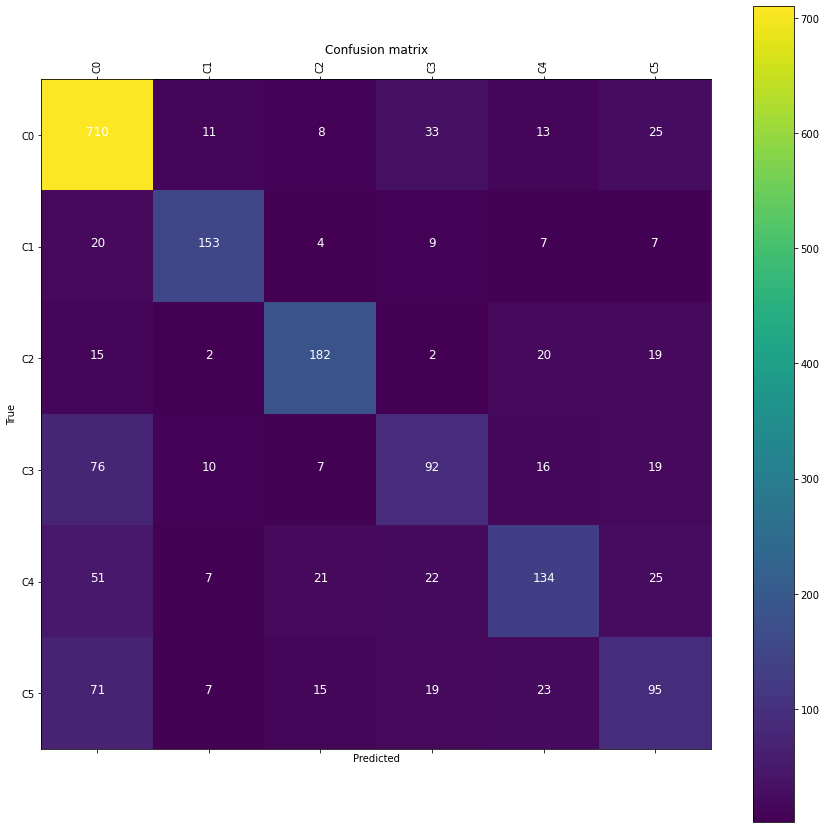

In [29]:
plot_cm(cmv)

### 3.2 Red convolucional profunda - EfficientNetB0

In [30]:
import random
C0_dir = os.path.join(train_dir, "C0")
files = os.listdir(C0_dir)
files = random.sample(files, 2800) 
for file in files: 
    f = os.path.join(C0_dir, file)
    os.remove(f)

In [31]:
datagen2 = ImageDataGenerator(zoom_range=0.2, 
                                    width_shift_range=0.1, 
                                    height_shift_range = 0.1, 
                                    rotation_range=15,
                                    fill_mode="nearest",
                                    validation_split=0.20)

train2 = datagen2.flow_from_directory(train_dir,
                                    shuffle=True,
                                    target_size=(HEIGHT, WIDTH),
                                    subset='training',
                                    class_mode='categorical')

val2 = datagen2.flow_from_directory(train_dir,
                                    shuffle=False,
                                    target_size=(HEIGHT, WIDTH),
                                    subset='validation',
                                    class_mode='categorical')

Found 5560 images belonging to 6 classes.
Found 1390 images belonging to 6 classes.


In [32]:
NUM_TRAIN = len(train2.filenames)
NUM_VAL = len(val2.filenames)

In [33]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers

def build_model_effNet():
    inputs = layers.Input(shape=(HEIGHT, WIDTH, 3))
    model = EfficientNetB0(include_top=False, input_tensor=inputs, weights="imagenet")
    for layer in model.layers[-20:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(6, activation="softmax", name="pred")(x)

    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    return model

In [34]:
model_effNet = build_model_effNet()
model_effNet = compile_model(model_effNet)

In [35]:
model_effNet.summary()

Model: "EfficientNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 224, 224, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization[0][0]              
_______________________________________________________________________________________

In [36]:
callbacks = create_callbacks(path='./model_effnet.h5')

In [37]:
history_eff = model_effNet.fit_generator(train2, 
                                    epochs=EPOCHS, 
                                    workers=16,
                                    steps_per_epoch=NUM_TRAIN // BATCH_SIZE, 
                                    validation_data=val2, 
                                    validation_steps=NUM_VAL // BATCH_SIZE,
                                    shuffle=True,
                                    callbacks=callbacks)

Epoch 1/30
173/173 [==============================] - 51s 250ms/step - loss: 1.6680 - f1_score: 0.4355 - accuracy: 0.4377 - val_loss: 0.8060 - val_f1_score: 0.7225 - val_accuracy: 0.7231

Epoch 00001: val_f1_score improved from -inf to 0.72255, saving model to .\model_effnet.h5
Epoch 2/30
173/173 [==============================] - 43s 244ms/step - loss: 0.5923 - f1_score: 0.8015 - accuracy: 0.8016 - val_loss: 0.5198 - val_f1_score: 0.8307 - val_accuracy: 0.8307

Epoch 00002: val_f1_score improved from 0.72255 to 0.83071, saving model to .\model_effnet.h5
Epoch 3/30
173/173 [==============================] - 41s 237ms/step - loss: 0.4291 - f1_score: 0.8487 - accuracy: 0.8475 - val_loss: 0.4294 - val_f1_score: 0.8594 - val_accuracy: 0.8590

Epoch 00003: val_f1_score improved from 0.83071 to 0.85939, saving model to .\model_effnet.h5
Epoch 4/30
173/173 [==============================] - 41s 232ms/step - loss: 0.3147 - f1_score: 0.8887 - accuracy: 0.8874 - val_loss: 0.4061 - val_f1_score: 

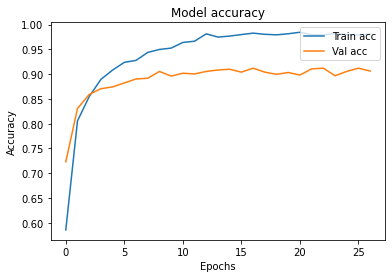

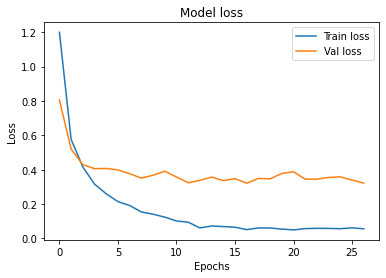

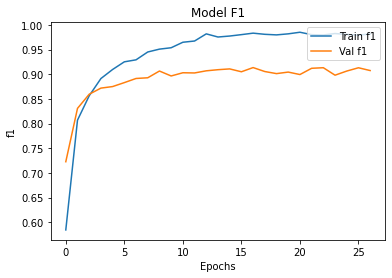

In [38]:
plot_accuracy(history_eff)
plot_loss(history_eff)
plot_f1(history_eff)

In [39]:
val_pred3=model_effNet.predict_generator(val2,verbose=0)
predicted_class_indices3=np.argmax(val_pred3,axis=1)

In [40]:
labels = (val2.class_indices)
labels = dict((v,k) for k,v in labels.items())
val_labels = [labels[k] for k in val2.labels]
predictions3 = [labels[k] for k in predicted_class_indices3]

In [41]:
print(f'\n Report:\n {classification_report(val_labels, predictions3)}')


 Report:
               precision    recall  f1-score   support

          C0       0.92      0.98      0.95       240
          C1       0.96      0.96      0.96       200
          C2       0.89      0.94      0.91       240
          C3       0.93      0.91      0.92       220
          C4       0.89      0.78      0.83       260
          C5       0.90      0.91      0.90       230

    accuracy                           0.91      1390
   macro avg       0.91      0.91      0.91      1390
weighted avg       0.91      0.91      0.91      1390



In [42]:
cm = confusion_matrix(val_labels, predictions3)

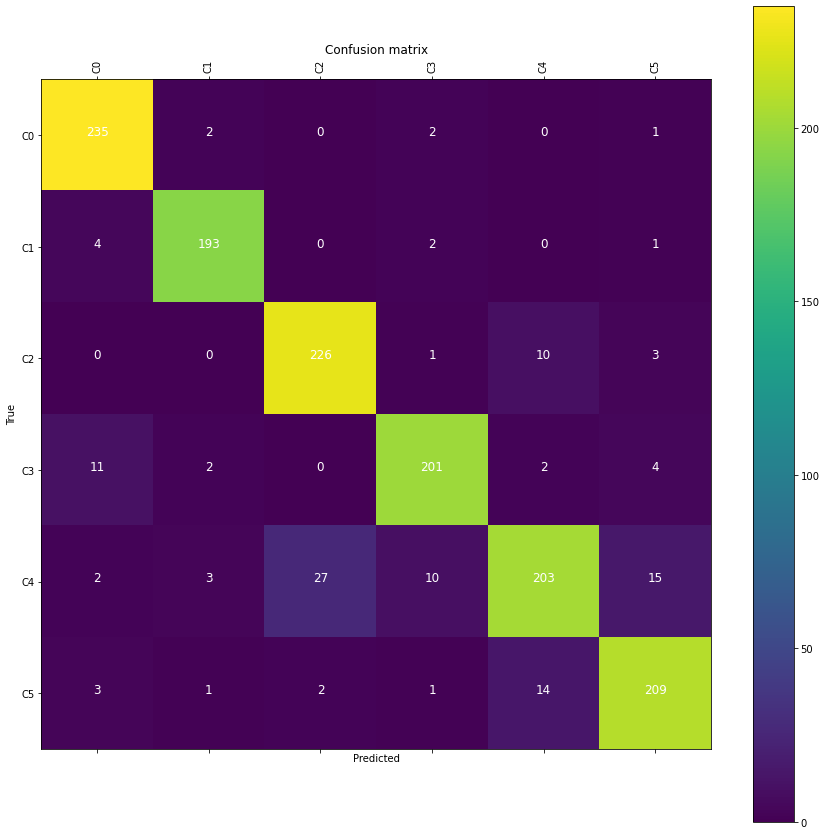

In [43]:
plot_cm(cm)

# 4. Evaluación test 

In [44]:
dataTest = ImageDataGenerator()
test_gen = dataTest.flow_from_directory(test_dir,
                                    target_size=(HEIGHT, WIDTH),
                                    shuffle=False,
                                    class_mode='categorical')

Found 7527 images belonging to 1 classes.


In [45]:
pred = model_effNet.predict_generator(test_gen)
predicted_class_indices_test=np.argmax(pred,axis=1)
predicted_class_indices_test[10:20]

array([3, 0, 3, 5, 4, 2, 3, 3, 3, 4], dtype=int64)

In [46]:
predictions_test = [labels[k] for k in predicted_class_indices_test]
predictions_test[10:20]

['C3', 'C0', 'C3', 'C5', 'C4', 'C2', 'C3', 'C3', 'C3', 'C4']

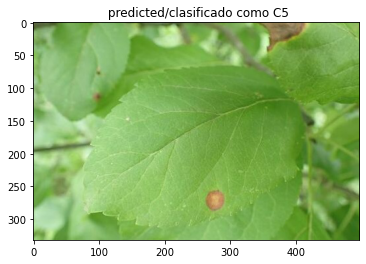

In [47]:
image = imread(test_dir + "\\" + test_gen.filenames[0])
plt.imshow(image)
plt.title(' predicted/clasificado como ' + predictions_test[0])
plt.show()

## 4.1 Save predictions csv

In [48]:
filenames = [x.split("\\")[1] for x in test_gen.filenames]

In [49]:
results=pd.DataFrame({"image":filenames,
                      "label":predictions_test})
results.to_csv("test.csv",index=False)

In [50]:
results.head(5)

,image,label
0,00VXsHo3Tl.jpg,C5
1,00xxC8yIDE.jpg,C5
2,00z8ig2jyH.jpg,C4
3,01LvXInxnh.jpg,C3
4,01x9dFzBB7.jpg,C3


In [51]:
results.label.value_counts()

C3    3208
C5    1985
C0    1008
C2     695
C4     414
C1     217
Name: label, dtype: int64